In [385]:
%matplotlib inline
from multisim.multisim import *
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv
import pfilter.pfilter as pf
from scipy.stats import norm
import seaborn as sns

In [386]:
# set up system
nsteps = 500

tfaulton  = 0.1
tfaultoff = 0.3
tend      = 3.0

time   = np.linspace(0,tend,nsteps)
step   = time[1]

time_1 = [t for t in time if t < tfaulton]
time_2 = [t for t in time if t > tfaulton and t < tfaultoff]
time_3 = [t for t in time if t > tfaultoff]


# We'll use these indexes to apply and remove the fault on the time loop
time_on_idx  = len(time_1)
time_off_idx = len(time_1) + len(time_2)


# create system: this can be a file that we parse
dsystem = System()
dsystem.silent()

for i in range(2):
    dsystem.addbus(i)

dsystem.buses[0].setvinit(cmath.rect(1.04, 0))
dsystem.buses[1].setvinit(cmath.rect(1.01613, (np.pi/180.0)*-3.3252))

dsystem.addbranch(0, 1, 0.0001, 0.0576)
dsystem.createYbusReal()

gen1 = GenCLS(0, 5.0, 1.0)
gen1.setinitpow(1.06496, 0.45996)

load = ZLoad(1, (1.03123 + 1j*-0.37616))

dsystem.adddevice(gen1)

dsystem.addload(load)

In [387]:
#######################################
#######################################
##  FUNCTIONS FOR FILTERING         ###
##                                  ###
#######################################
#######################################

# theta = [H xd eqp], u = [pm eqp]
# assume we have good grip on states
def prior(x, w, mean, prior_var):
    size = len(w)
    for i in range(size):
        x[0,i] = mean[0] #+ mean[0]*np.random.normal(0, prior_var)
        x[1,i] = mean[1] #+ mean[1]*np.random.normal(0, prior_var)

def measurement(theta, x, y, volt, meas_var):
    size = y.shape[1]
    for i in range(size):

        H   = theta[0]
        xd  = theta[1]
        eqp = theta[2]
        pm  = theta[3]

        vt    = np.abs(volt[0] + 1j*volt[1])
        angle = cmath.phase(volt[0] + 1j*volt[1])

        xold = x[:, i]
        delta = xold[0]
        
        vd = vt*np.sin(xold[0] - angle)
        vq = vt*np.cos(xold[0] - angle)
        
        i_d = (eqp - vq)/xd
        i_q = vd/xd
        
        y[0, i] = i_q# + np.random.normal(0, meas_var)
        y[1, i] = i_d# + np.random.normal(0, meas_var)
        
        #y[0, i] = np.sin(delta)*i_d + np.cos(delta)*i_q  #+ np.random.normal(0, meas_var)
        #y[1, i] = -np.cos(delta)*i_d + np.sin(delta)*i_q #+ np.random.normal(0, meas_var)

def likelihood(w, y, meas_curr, meas_var):
    size = y.shape[1]
    for i in range(size):
        w[i] = norm.pdf(y[0, i] - meas_curr[0], 0, meas_var)*norm.pdf(y[1, i] - meas_curr[1], 0, meas_var)
        
        
def rfunct(x, volt, theta):
    
    F = np.zeros(2)
    
    H   = theta[0]
    xd  = theta[1]
    eqp = theta[2]
    pm  = theta[3]

    vd = volt[0]*np.sin(x[0]) - volt[1]*np.cos(x[0])
    vq = volt[0]*np.cos(x[0]) + volt[1]*np.sin(x[0])
    
    F[0] =  (2*np.pi*60.0*x[1])
    F[1] =  (pm - vq*vd/xd - vd*(eqp - vq)/xd)/(2.0*H)
        
    return F

def rfunct_non(x, xold, volt, theta, h):
    
    F = np.zeros(2)
    
    H   = theta[0]
    xd  = theta[1]
    eqp = theta[2]
    pm  = theta[3]

    vd = volt[0]*np.sin(x[0]) - volt[1]*np.cos(x[0])
    vq = volt[0]*np.cos(x[0]) + volt[1]*np.sin(x[0])
    
    F[0] =  x[0] - xold[0] - h*(2*np.pi*60.0*x[1])
    F[1] =  x[1] - xold[1] - h*(pm - vq*vd/xd - vd*(eqp - vq)/xd)/(2.0*H)
        
    return F
        
def propagate_corr(theta, x, volt, volt_prev, h):
    
    
    size = x.shape[1]
    for i in range(size):

        x_kh = x[:, i] + h*rfunct(x[:, i], volt_prev, theta)
        f_kh = (rfunct(x_kh, volt, theta) + rfunct(x[:, i], volt, theta))/2.0
        
        x[:, i] = x[:, i] + h*f_kh
        
def propagate_non(theta, x, volt, volt_prev, h):
    
    
    size = x.shape[1]
    for i in range(size):

        sol = optimize.root(rfunct_non, x[:, i], args = (x[:,i], volt, theta, h))
        
        x[0, i] = sol.x[0]
        x[1, i] = sol.x[1]
        
def propagate(theta, x, volt, volt_prev, h):

    vt    = np.abs(volt[0] + 1j*volt[1])
    angle = cmath.phase(volt[0] + 1j*volt[1])
    
    size = x.shape[1]
    for i in range(size):
                
        H   = theta[0]
        xd  = theta[1]
        eqp = theta[2]
        pm  = theta[3]

        xold = x[:, i]
              
        #vd = vt*np.sin(xold[0] - angle)
        #vq = vt*np.cos(xold[0] - angle)
        vd = volt[0]*np.sin(xold[0]) - volt[1]*np.cos(xold[0])
        vq = volt[0]*np.cos(xold[0]) + volt[1]*np.sin(xold[0])
        
        #print pm, vq*vd/xd - vd*(eqp - vq)/xd
        x[0, i] = x[0, i] + h*(2*np.pi*60.0*xold[1])
        x[1, i] = x[1, i] + h*(pm - vq*vd/xd - vd*(eqp - vq)/xd)/(2.0*H)

In [388]:
#######################################
#######################################
##  FUNCTIONS FOR CONTROL           ###
##                                  ###
#######################################
#######################################

def propagate_control(theta, x, u, volt, h):
    
    size = x.shape[1]
    for i in range(size):
                
        H   = theta[0]
        xd  = theta[1]
        eqp = theta[2]
        pm  = u[0, i]

        vt    = np.abs(volt[0] + 1j*volt[1])
        angle = cmath.phase(volt[0] + 1j*volt[1])

        xold = x[:, i]
        
        vd = vt*np.sin(xold[0] - angle)
        vq = vt*np.cos(xold[0] - angle)
                
        #print pm, vq*vd/xd - vd*(eqp - vq)/xd
        x[0, i] = x[0, i] + h*(2*np.pi*60.0*xold[1]) # + np.random.normal(0, 0.01, 1)
        x[1, i] = x[1, i] + h*(pm - vq*vd/xd - vd*(eqp - vq)/xd)/(2.0*H) #+ np.random.normal(0, 0.001, 1)
        
        
def propagate_u(u, var):
    
    size = u.shape[1]
    for i in range(size):
        u[0, i] = u[0, i] + np.random.uniform(-var, var, 1)
        
def setpoint(x, s):
    
    size = x.shape[1]
    for i in range(size):
        s[0, i] = x[1, i] 
        
def weight_set(w, s, setpoint, set_var):
    size = s.shape[1]
    for i in range(size):
        w[i] = w[i]*norm.pdf(s[0, i] - setpoint, 0, set_var)
    

In [389]:
# INITIALIZE SYSTEM AND PARTICLE FILTER
# Solve system
x = initialize_system(dsystem)

print x

# allocate array for trajectory plus steady-state solutions
trajectory = np.zeros((len(x), len(time)))
trajectory[:,0] = np.copy(x)

# initialize particle filter and priors
nparticles = 1
meas_noise = 3e-3
model_var = 0.01
meas_var  = 8e-2
prior_var = 0.1

# model parametes
theta = [gen1.H, gen1.xd, gen1.e_q, gen1.p_m]

# init cloud 
x_dim = 2
y_dim = 2
cl = pf.cloud(nparticles, x_dim, y_dim)
exp_n = np.zeros((x_dim, len(time)))

# prior sampling
meas_volt = x[6:8]#  + np.random.normal(0, meas_noise, 2)
meas_volt_prev = 

meas_curr = x[4:6]#  + np.random.normal(0, meas_noise, 2)


prior(cl.x, cl.w, [x[0], x[1]], prior_var = 0.1)


measurement(theta, cl.x, cl.y, meas_volt, meas_var)

likelihood(cl.w, cl.y, meas_curr, meas_var)
pf.normalize(cl.w)

exp_n[0, 0] = np.average(cl.x[0,:], axis = 0, weights=cl.w)
exp_n[1, 0] = np.average(cl.x[1,:], axis = 0, weights=cl.w) 

1.80158210262 1.06496
[  6.04546855e-01  -9.28962602e-27   8.55670134e-01   5.91124878e-01
   5.91124878e-01   9.45911968e-01   1.04000000e+00   0.00000000e+00
   1.01441925e+00  -5.89387053e-02]


In [390]:
# CREATE CONTROL PARTICLE FILTER

npart_mpc = 100
L = 50
mpc_pf = pf.cloud_control(npart_mpc, 2, 1, 1)

In [391]:
for i in range(len(time) - 3):
    
    ############################
    ##### SIMULATION LOOP  #####
    ############################
    
    if (i == time_on_idx):
        fault_id = dsystem.applyBusFault(1, 0.01)
        trajectory[:, i + 1] = solve_steady_system(trajectory[:, i], dsystem)
        
    elif (i == time_off_idx):
        dsystem.removeBusFault(fault_id)
        trajectory[:, i + 1] = solve_steady_system(trajectory[:, i], dsystem)
        
    else:
        trajectory[:, i + 1] = propagate_system(trajectory[:, i], dsystem, step)
        

        
    # GENERATE MEASUREMENTS
    
    meas_volt = trajectory[6:8, i + 1]#  + np.random.normal(0, meas_noise, 2)
    meas_curr = trajectory[4:6, i + 1]#  + np.random.normal(0, meas_noise, 2)
        
    ############################
    ##### FILTERING LOOP   #####
    ############################
    
    if (i == time_on_idx or i == time_off_idx):
        exp_n[0, i + 1] = np.average(cl.x[0,:], axis = 0, weights=cl.w)
        exp_n[1, i + 1] = np.average(cl.x[1,:], axis = 0, weights=cl.w)         
    else:
        cl.x = pf.resample_systematic(cl.w, cl.x)
        cl.w = (1.0/nparticles)*np.ones(nparticles)
        propagate_non(theta, cl.x, meas_volt, meas_volt_prev, step)
    
        # store measurement
        meas_volt_prev = meas_volt

    
        measurement(theta, cl.x, cl.y, meas_volt, meas_var)
        likelihood(cl.w, cl.y, meas_curr, meas_var)
        pf.normalize(cl.w)
        exp_n[0, i + 1] = np.average(cl.x[0,:], axis = 0, weights=cl.w)
        exp_n[1, i + 1] = np.average(cl.x[1,:], axis = 0, weights=cl.w) 
    
    ############################
    ##### CONTROL   LOOP   #####
    ############################
    
    if (0):
   
    # update states of particle cloud
        for j in range(npart_mpc):
            mpc_pf.x[:, j]  = trajectory[0:2, i + 1]
            mpc_pf.u[0, j]  = dsystem.devices[0].p_m + np.random.uniform(-0.2, 0.2, 1)
            mpc_pf.uk[0, j] = mpc_pf.u[0, j]
        
    # propagate for horizon
        for j in range(L):
            
            mpc_pf.x, mpc_pf.u, mpc_pf.uk = pf.resample_systematic_control(mpc_pf.w, mpc_pf.x, 
                mpc_pf.u, mpc_pf.uk)
            mpc_pf.w = (1.0/npart_mpc)*np.ones(npart_mpc)
            
            propagate(theta, mpc_pf.x, mpc_pf.uk, meas_volt, step)
        
            setpoint(mpc_pf.x, mpc_pf.s)
            weight_set(mpc_pf.w, mpc_pf.s, 0.0, 0.01)
            pf.normalize(mpc_pf.w)
            propagate_u(mpc_pf.uk, 0.1)
                
        # calculate control
        u_set = np.average(mpc_pf.u[0,:], axis = 0, weights=mpc_pf.w)
        print "At time %g apply control %f" % (time[i], u_set)
    
        dsystem.devices[0].p_m = u_set
        
        print pf.neff(mpc_pf.w)

>>>APPLYING FAULT at bus: 1, z: 0.01.
Solve steady state
<<<REMOVING FAULT at bus: 1, z: 0.01.
Solve steady state


In [392]:
f, axes = plt.subplots(2, 1, figsize=(20, 21))


axes[0].plot(time[:-1], exp_n[0,:-1])
axes[0].plot(time, trajectory[0,:])
axes[1].plot(time[:], exp_n[1,:])
axes[1].plot(time[:], trajectory[1,:])

#axes[0].plot(time[:-1], exp_n[0,:-1])
#axes[0].plot(time, trajectory[0,:])
#axes[1].plot(time[40:60], exp_n[1,40:60])
#axes[1].plot(time[40:60], trajectory[1,40:60])

#axes[0].plot(exp_n[1,40:100])
#axes[0].plot(trajectory[1,41:101])


[ 0.24048096  0.24649299  0.25250501  0.25851703  0.26452906  0.27054108
  0.27655311  0.28256513  0.28857715  0.29458918  0.3006012   0.30661323
  0.31262525  0.31863727  0.3246493   0.33066132  0.33667335  0.34268537
  0.34869739  0.35470942  0.36072144  0.36673347  0.37274549  0.37875752
  0.38476954  0.39078156  0.39679359  0.40280561  0.40881764  0.41482966
  0.42084168  0.42685371  0.43286573  0.43887776  0.44488978  0.4509018
  0.45691383  0.46292585  0.46893788  0.4749499 ]
[ 0.01370313  0.01432595  0.01494877  0.01557159  0.0161944   0.01681722
  0.01744004  0.01806286  0.01868567  0.01930849  0.01993131  0.01993131
  0.01993138  0.01993144  0.01993151  0.01993158  0.01993165  0.01993171
  0.01993178  0.01993185  0.01993192  0.01993198  0.01993205  0.01993212
  0.01993219  0.01993225  0.01993232  0.01993239  0.01993246  0.01993252
  0.01993259  0.01993266  0.01993273  0.0199328   0.01993286  0.01993293
  0.019933    0.01993307  0.01993313  0.0199332 ]
[ 0.01370313  0.01432595 

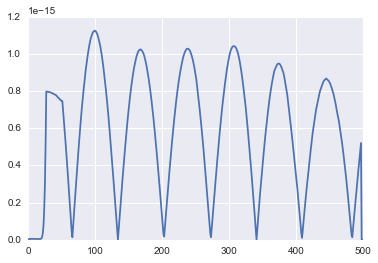

In [393]:
print time[40:80]
print trajectory[1, 40:80]
print exp_n[1, 40:80]

plt.plot(abs(trajectory[1, :] - exp_n[1,:]))

[  6.04547008e-01   6.75341155e-08   8.55690112e-01   5.91062526e-01
   5.91062526e-01   9.45891990e-01   1.03998100e+00   6.28149641e-05
   1.01440281e+00  -5.88717512e-02]


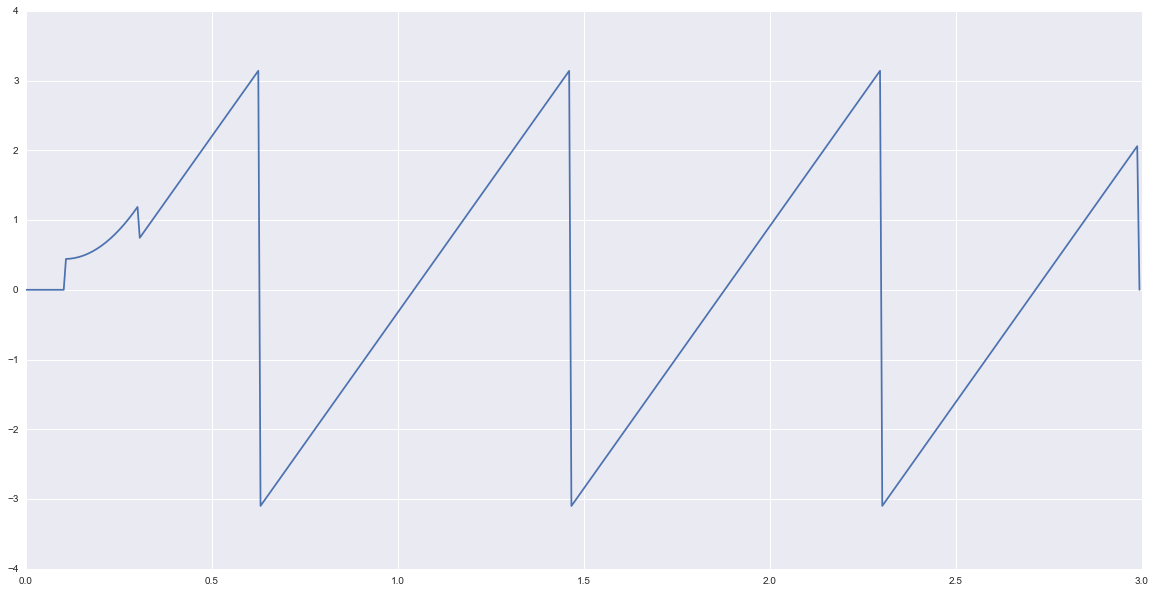

In [394]:
print trajectory[:,1]

plt.figure(figsize=(20,10))
plt.plot(time[:-1], np.abs(trajectory[6,:-1] + 1j*trajectory[7,:-1]))

plt.figure(figsize=(20,10))
plt.plot(time[:-1], np.angle(trajectory[6,:-1] + 1j*trajectory[7,:-1]))